# Cosine Difference

##### New Characteristic Loss 

The underlying idea is that the differences from a face to the mean face represent its most distinctive features and thus should be kept after exaggeration. For example, if a face has a larger nose compared to a normal face, this distinctiveness will be preserved or even exaggerated after converting to caricature.

This is achieved by penalising the cosine differences between input landmark lx ∈ LX and the predicted one GLY (lx ) after subtracting its corresponding means:

* $ L_{cha}^{L_Y} (G_{L_Y}) = E_{l_x  L_X}[1 - cos(l_x - \overline{L_X}, G_{L_Y}(l_x) - \overline{L_{Y}})]$
* $ L_{cha}^{L_X} (G_{L_X}) = E_{l_y  L_Y}[1 - cos(l_y - \overline{L_Y}, G_{L_X}(l_y) - \overline{L_{X}})]$


<b>Definitions:</b>
* $cos$ - represents the cosine difference
* $l_{x}$ - individual pca_vector within pca_matrix relating to image $x \in X$
* $l_{y}$ - individual pca_vector within pca_matrix relating to image $y \in Y$
* $\overline{L_X}$ - mean of pca_matrix X

* $\overline{L_Y}$ - mean of pca_matrix Y
* $l_x - \overline{L_X}$ - difference between given pca vector x and mean of pca_matrix X
* $l_y - \overline{L_Y}$ - difference between given pca vector y and mean of pca_matrix Y

* $G_{L_Y}(l_x) - \overline{L_{Y}}$ - difference between generated (fake) pca vector y and mean of pca_matrix Y

<b>Resources:</b>
* https://medium.com/@zhang_yang/cosine-similarity-dot-product-for-normalized-vectors-c07bdb61c9d1

NOTE: cosine difference is simply 1 minus cosine similarity

### Cosine Difference Definition

https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval (0,π] radians. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors oriented at 90° relative to each other have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. 

Cosine difference $d$ is simply 1 - cosine similarity, where A and B are vectors

$$ d = 1 - \frac{A \cdot B} {\mid\mid A \mid\mid \mid\mid B \mid\mid}$$

Very simply put it is a measure of how similar to vectors are ignoring their length. If they have the same direction the similarity is 1. if they are orthogonal the similarity is 0. if their directions are opposite their similarity is -1.

### Cosine Difference in Higher Dimensional Space:

The top answer on this stackoverflow link gives a really simple example about cosine similarity in higher dimension space

https://stackoverflow.com/questions/1746501/can-someone-give-an-example-of-cosine-similarity-in-a-very-simple-graphical-wa

### Cosine Difference Numpy/Scipi/Sklearn Implementation: 2D

In [1]:
# cosine distance exapmle

# both packages used to calc cosine distance, one for vector calc and one for matrix calc
# we will check one against the other
import scipy.spatial.distance as spat_dist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# example of cosine distance claculaion for vector
cosine_distance = spat_dist.cosine(np.array([2, 0]), np.array([1, 0]))
print('cosine distance of vectors with same direction: ' + str(cosine_distance))
cosine_distance = spat_dist.cosine(np.array([0, 2]), np.array([1, 0]))
print('cosine distance of orthoganol vectors: ' + str(cosine_distance))
cosine_distance = spat_dist.cosine(np.array([-5, 0]), np.array([1, 0]))
print('cosine distance of vectors with opposite directions: ' + str(cosine_distance))


cosine distance of vectors with same direction: 0.0
cosine distance of orthoganol vectors: 1.0
cosine distance of vectors with opposite directions: 2.0


### Cosine Difference Numpy/Scipi/Sklearn Implementation: Multi Dimensional

In [2]:
# import some data: note the shape of these csv are n rows x 32 columns - where the 32 columns
# represent the 32 principle components that we feed into our neural network
real_Y = pd.read_csv('coords_pca_Y.csv', index_col=0).to_numpy()
real_X = pd.read_csv('coords_pca_X.csv', index_col=0).to_numpy()

# define some arbitrary fake_X for the purposes of the example
# in reality this will be the output of the generator network
fake_X = real_Y + (np.ones_like(real_Y)*3.0)

real_mean_Y = np.matmul(np.ones(real_Y.shape[0]).reshape(-1,1), real_Y.mean(axis=0).reshape(1,-1))
real_mean_X = np.matmul(np.ones(real_Y.shape[0]).reshape(-1,1), real_X.mean(axis=0).reshape(1,-1))

# real_y minus mean of real_Y for all y in Y
np_A = real_Y - real_mean_Y

# fake_x minus mean of X for all y in Y
np_B = fake_X - real_mean_X

cosine_distance_matrix = np.multiply(np.ones((real_Y.shape[0],1)) - cosine_similarity(np_A, np_B, dense_output=True),
                                     np.eye(real_Y.shape[0]))

cosine_distance_vector = cosine_distance_matrix.sum(axis=0)



# check that each entry in our distance vector is equal to the distance of each vector in matrix A and B  
for i in range(real_Y.shape[0]):
    assert(abs(spat_dist.cosine(np_A[1], np_B[1]) - cosine_distance_vector[1])<0.00000001)
    

We now need to implement this in tensorflow and wrap in a helper function. 

### Cosine Difference Tensorflow Implementation

We now implement the equivalent function in tensorflow and test the output against our numpy calculatation above.

In [3]:
## loss function
def cosine_distance(real_1, real_mean_1, fake_2, real_mean_2):

    # real_y minus mean of real_Y for all y in Y
    A = real_1 - real_mean_1

    # fake_x minus mean of X for all y in Y
    B = fake_2 - real_mean_2

    normalize_A = tf.nn.l2_normalize(A,1)        
    normalize_B = tf.nn.l2_normalize(B,1)
    
    distance_matrix = 1 - tf.matmul(normalize_A, normalize_B, transpose_b=True)

    distance_matrix = tf.diag_part(distance_matrix)
    
    distance = tf.reduce_sum(distance_matrix)
    
    return distance_matrix, distance
    

We will now test that the output of our tesorflow helper function is equivalent to our numpy implementation above.

In [4]:
# reset graph
from tensorflow.python.framework import ops
ops.reset_default_graph()
g = tf.get_default_graph()

# take copies
#real_Y = np_Y
#real_X = np_X
#fake_X = np_Y + (np.ones_like(np_Y)*3.0)

# init placeholders
test_A = tf.placeholder(tf.float32,[None, 140], name='test_A')
test_B = tf.placeholder(tf.float32,[None, 140], name='test_B')
test_C = tf.placeholder(tf.float32,[None, 140], name='test_C')
test_D = tf.placeholder(tf.float32,[None, 140], name='test_D')

# define cos dist
cost_mat, cos_dist = cosine_distance(test_A, test_B, test_C, test_D)

# calculate numpy cosine distance
with tf.Session() as sess_test:

    output_cos_mat, output_cost_dist = sess_test.run([cost_mat, cos_dist], feed_dict={test_A: real_Y, 
                                                                                      test_B: real_mean_Y,
                                                                                      test_C: fake_X, 
                                                                                      test_D: real_mean_X})

assert((output_cost_dist - cosine_distance_vector.sum()) < 0.001)

### Optimizing Cosine Difference in Tensorflow

We need to be able to do more than just calculate the cosine differnce in tensorflow, we actually need to be able to minimise it over a number of iterations. We will look at a simple vector example to see how this can be done. 

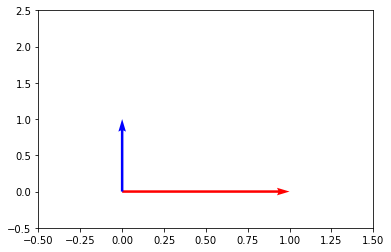

In [5]:
vector_A = np.array([1, 0]).reshape(1,2)
vector_B = np.array([0, 1]).reshape(1,2)
origin = np.array([0, 0])

plt.xlim((-0.5,1.5));
plt.ylim((-0.5,2.5));
plt.quiver(*origin, vector_A, vector_B, color=['r','b'],angles='xy', scale_units='xy', scale=1);


We aim to build a simple network which minimises the cosine difference (maximise the cosine similarity) between vector_A and vector_B, keeping vector_A constant. Essentially as we itterate and calculate the new position of vector_B we would expect the blue vector to get closer and closer to the red vector in the diagram above.

In [6]:
## loss function: 
## note: compared to cosine_distance function above I have removed subtracting mean for purposes 
## of this simple example
def cosine_distance_simple(A, B):

    normalize_A = tf.nn.l2_normalize(A,1)        
    normalize_B = tf.nn.l2_normalize(B,1)

    distance_matrix = 1 - tf.matmul(normalize_A, normalize_B, transpose_b=True)

    distance_matrix = tf.diag_part(distance_matrix)

    distance = tf.reduce_sum(distance_matrix)

    return distance

### Helper Functions

In [7]:
import math
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops

# from utils import *

##### New Helper Functions

# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=1.0)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)
 

def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_units])
    b = bias_variable(name, [num_units])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        #layer = tf.nn.relu(tf.nn.tanh(layer))
        layer = tf.nn.relu(layer)
    return layer


### Loss functions

In [8]:
## loss function
def cosine_distance_simple(A, B):

    normalize_A = tf.nn.l2_normalize(A,1)        
    normalize_B = tf.nn.l2_normalize(B,1)

    distance_matrix = 1 - tf.matmul(normalize_A, normalize_B, transpose_b=True)

    distance_matrix = tf.diag_part(distance_matrix)

    distance = tf.reduce_sum(distance_matrix)
    
    #distance = tf.losses.cosine_distance(A,B,axis=1)

    return distance

def maintain_length(A, B):

    return abs(tf.norm(A) - tf.norm(B))

    

### Neural Network

In [9]:
from __future__ import division
import tensorflow as tf

# generator network without residual block
def generator(vector, reuse=False, name="generator"):

    with tf.variable_scope(name):
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
            
        output_dimension = vector.shape[1]

        e1 = fc_layer(vector, 64, name='g_e1', use_relu=True)
        e2 = fc_layer(e1, 128, name='g_e2', use_relu=True)    
        e3 = fc_layer(e2, 256, name='g_e3', use_relu=True)
        e4 = fc_layer(e3, 512, name='g_e4', use_relu=True)
        e5 = fc_layer(e4, 256, name='g_e5', use_relu=True)
        e6 = fc_layer(e5, 128, name='g_e6', use_relu=True)
        e7 = fc_layer(e6, 64, name='g_e7', use_relu=True)
        e8 = fc_layer(e7, output_dimension, name='g_e8', use_relu=False)


        return e8


### Model

In [10]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
import numpy as np
from collections import namedtuple
from sklearn.model_selection import train_test_split

# from module import *
# from utils import *

class cosine_diff_test(object):
    def __init__(self, sess, args):
        # initialise tensorflow session
        self.sess = sess
                
        # data, test, train splits
        self.data_A = args.vA
        self.data_B = args.vB
        
        self.generator = generator
        
        # when an instance of class cycleGAN is created, build model is automatically called
        self._build_model()
        
        
    def _build_model(self):
        
        #### INPUTS TO NETWORKS
        # placeholder for vectors
        self.vector_A = tf.placeholder(tf.float32,
                                     [None, 2],
                                     name='vector_A')
        self.vector_B = tf.placeholder(tf.float32,
                                    [None, 2],
                                    name='vector_B')
        
        # FCNN to determine vector move required
        self.vector_B_ = self.generator(self.vector_B, False, name="generatorB")
        
        # minimise cos_dist between A and B while keeping A same
        self.dist = cosine_distance_simple(self.vector_A, self.vector_B_)
        self.len = maintain_length(self.vector_B, self.vector_B_)
        
        self.loss = cosine_distance_simple(self.vector_A, self.vector_B_) \
                    + maintain_length(self.vector_B, self.vector_B_)
        
        # trainable variables
        t_vars = tf.trainable_variables()

        # training variables for generator
        self.g_vars = [var for var in t_vars if 'generator' in var.name]


    def train(self, args):
        # placeholder for learning rate
        self.lr = tf.placeholder(tf.float32, None, name='learning_rate')

        # define optimizer
        self.optimimizer = tf.train.AdamOptimizer(self.lr, beta1=args.beta1).minimize(self.loss, var_list=self.g_vars)
        
        
        # initialise global varibles and run session
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        
        # learning rate
        lr = args.lr
        
        
        # iterate over the number of epochs definied
        for epoch in range(args.epoch):
            
            # Import Data
            vecA = self.data_A.copy()
            vecB = self.data_B.copy()
            
            # Update 
            vector_B_transformed, _, loss_, dist_, len_ = self.sess.run(
                [self.vector_B_, self.optimimizer, self.loss, self.dist, self.len],
                feed_dict={self.vector_A: vecA, 
                           self.vector_B: vecB,  
                           self.lr: lr})
            
            # print loss summaries 
            if epoch % 1000 == 0:
                print('Total Loss: ', loss_, ', Cosine Distance: ', dist_, 
                      ', Input Vector Length - Output Vector Length: ', len_)
        
        print('Transformed vector: ', vector_B_transformed)

        


### Training Parameters

In [11]:
class Args():
    A_vec = np.array([0, 1]).reshape(1,2)
    B_vec = np.array([1, 0]).reshape(1,2)    
    ori = np.array([0, 0])
 
    epoch = 100000
    lr = 0.002
    vA = A_vec
    vB = B_vec
    beta1 = 0.5
    orig = ori
    
args = Args()

### Train and Output

In [12]:
# TRAIN
tf.reset_default_graph()

tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
with tf.Session(config=tfconfig) as sess:
    model = cosine_diff_test(sess, args)
    model.train(args) 

Total Loss:  273469.0 , Cosine Distance:  1.2342865 , Input Vector Length - Output Vector Length:  273467.78
Total Loss:  19949.8 , Cosine Distance:  0.16443694 , Input Vector Length - Output Vector Length:  19949.637
Total Loss:  11898.361 , Cosine Distance:  1.9985712 , Input Vector Length - Output Vector Length:  11896.362
Total Loss:  8281.815 , Cosine Distance:  0.009062409 , Input Vector Length - Output Vector Length:  8281.807
Total Loss:  1982.3037 , Cosine Distance:  1.9974986 , Input Vector Length - Output Vector Length:  1980.3062
Total Loss:  1903.7356 , Cosine Distance:  0.02151668 , Input Vector Length - Output Vector Length:  1903.7141
Total Loss:  1258.0659 , Cosine Distance:  1.2048289 , Input Vector Length - Output Vector Length:  1256.8611
Total Loss:  732.4259 , Cosine Distance:  0.21921992 , Input Vector Length - Output Vector Length:  732.20667
Total Loss:  1652.827 , Cosine Distance:  0.97938013 , Input Vector Length - Output Vector Length:  1651.8477
Total Loss:

Total Loss:  0.0011026859 , Cosine Distance:  5.9604645e-07 , Input Vector Length - Output Vector Length:  0.0011020899
Total Loss:  0.006572962 , Cosine Distance:  1.3709068e-06 , Input Vector Length - Output Vector Length:  0.006571591
Total Loss:  0.0011287928 , Cosine Distance:  2.3841858e-07 , Input Vector Length - Output Vector Length:  0.0011285543
Total Loss:  0.003591299 , Cosine Distance:  3.5762787e-07 , Input Vector Length - Output Vector Length:  0.0035909414
Total Loss:  0.00092720985 , Cosine Distance:  5.9604645e-07 , Input Vector Length - Output Vector Length:  0.0009266138
Total Loss:  0.0032573938 , Cosine Distance:  9.536743e-07 , Input Vector Length - Output Vector Length:  0.0032564402
Total Loss:  0.00050878525 , Cosine Distance:  2.3841858e-07 , Input Vector Length - Output Vector Length:  0.00050854683
Total Loss:  0.0027372837 , Cosine Distance:  4.7683716e-07 , Input Vector Length - Output Vector Length:  0.0027368069
Total Loss:  0.0011398792 , Cosine Distan

### Excersize: 

See if you can find a deep NN that can work out a mapping between any vectors within a circle of radius 1 and (0,1)

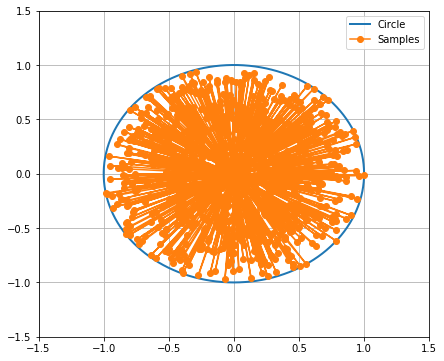

In [14]:
# generate random points in a circle
# https://gist.github.com/makokal/6883810

import numpy as np 
%matplotlib inline

num_samples = 1000

# make a simple unit circle 
theta = np.linspace(0, 2*np.pi, num_samples)
a, b = 1 * np.cos(theta), 1 * np.sin(theta)

# generate the points
# theta = np.random.rand((num_samples)) * (2 * np.pi)
r = np.random.rand((num_samples))
x, y = r * np.cos(theta), r * np.sin(theta)

# plots
plt.figure(figsize=(7,6))
plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')
plt.plot(x, y, marker='o', label='Samples')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.grid()
plt.legend(loc='upper right')
plt.show(block=True)

# reshape arrays
x = x.reshape(-1,1)
y = y.reshape(-1,1)
test = np.concatenate([x,y], axis=1)